## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [4]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [5]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [8]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]


(500, 2)


Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [147]:
t2_train = (t_multi_train >= 3).astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

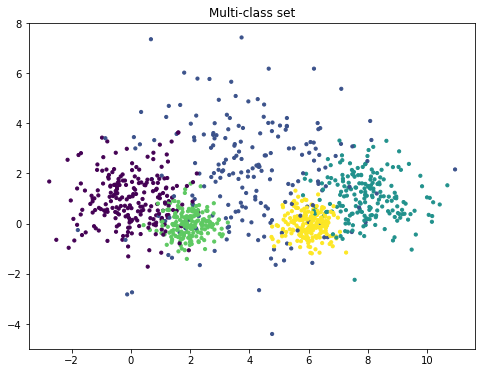

In [148]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

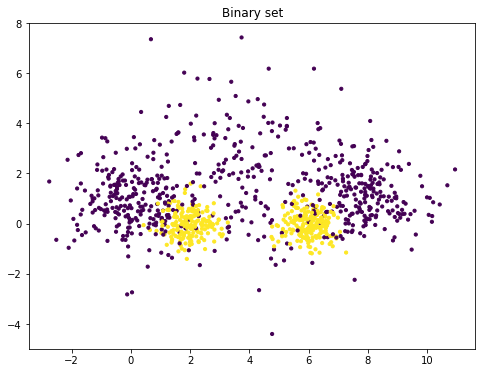

In [149]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [150]:
def add_bias(X, bias=1):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [151]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [152]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
                 
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [153]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [154]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
accuracy(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [155]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

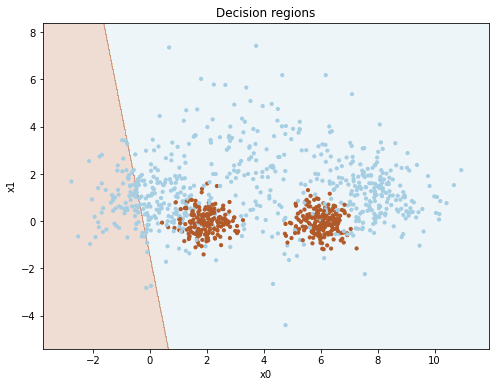

In [156]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

Helping method for finding the best hyper-parameter eta:

In [157]:
def optimalHyperParam(trainingdata, step, epochs, e=0.1):
    notBetter = 0
    cl.fit(trainingdata, t2_train, e, epochs)
    
    tmp = accuracy(cl.predict(X_val), t2_val)
    # saving best accuracy and the eta that gave this result in a tuple
    best = (tmp, e)             
    while notBetter < 10:       # until finding any better
        e += step
        cl.fit(trainingdata, t2_train, e, epochs)
        new = accuracy(cl.predict(X_val), t2_val)

        if new > best[0]:       
            best = (new, e)

        if new == tmp:
            notBetter += 1
        elif notBetter == 3 and tmp < best[0]:
            break
        
        tmp = new
    return best[1]

The accuracy came down to  0.704
With th best possible eta  0.07499999999999998  which I found with my function optimalHyperParam().
I could have done the same method for finding the epochs-parameter, but I rather experimented instead.
Incrementing by 50 each time, landing on 200, and then decreased by 5, to find the optimal value. 

After training the model, the plot includes the most optimal decision boundary classifying the data.


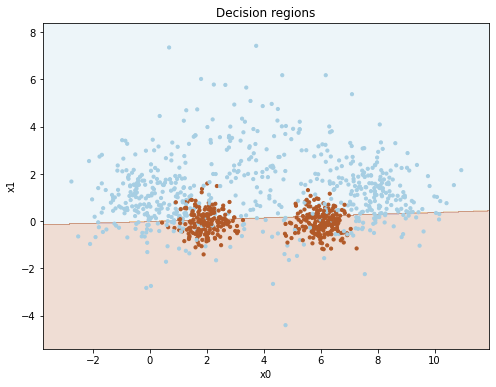

In [158]:
cl = NumpyLinRegClass()
epochs = 185
best_eta = optimalHyperParam(X_train, -0.005, epochs)
cl.fit(X_train, t2_train, eta=best_eta, epochs=epochs)
print("The accuracy came down to ", accuracy(cl.predict(X_val), t2_val))
print("With th best possible eta ", best_eta, " which I found with my function optimalHyperParam().")
print("I could have done the same method for finding the epochs-parameter, but I rather experimented instead.")
print("Incrementing by 50 each time, landing on 200, and then decreased by 5, to find the optimal value. \n")
print("After training the model, the plot includes the most optimal decision boundary classifying the data.")
plot_decision_regions(X_train, t2_train, cl)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

In [159]:
class NumpyLinRegClass(NumpyClassifier):
    
    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        org_x = X_train
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        self.losses, self.accuracies = [], []
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
            # adding loss and accuracy into lists
            self.losses.append(self.mse(t_train, X_train @ weights))
            self.accuracies.append(accuracy(self.predict(org_x), t_train))
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold
    
    # function for plotting loss and accuracy
    def plot_data(self):
        plt.plot(self.losses)
        plt.title("Loss")
        plt.show()
        plt.plot(self.accuracies)
        plt.title("Accuracy")
        plt.show()
    
    def mse(self, y, y_pred):
        return np.mean((y - y_pred)**2)

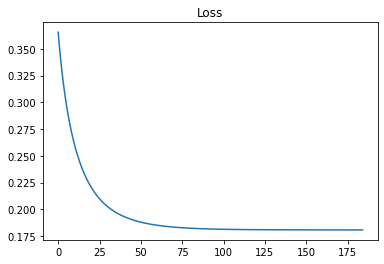

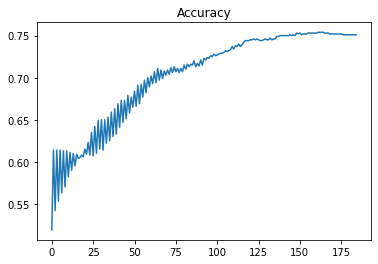

In [160]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, eta=0.076, epochs=185)
#print(accuracy(cl.predict(X_val), t2_val))
cl.plot_data()


### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

The best possible eta is 0.65
Both hyper-params I found in the same way as in the tuning task.
With the final hyper-meter settings, we have an accuracy on:  0.786


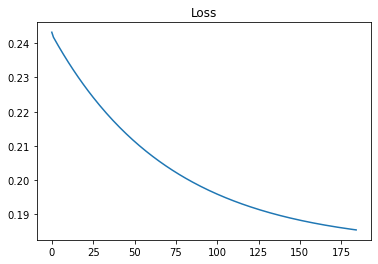

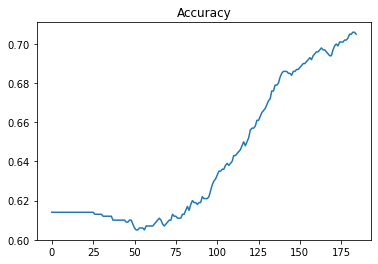

In [161]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

scaled_traindata = scale(X_train)
epo = 185
best_eta = optimalHyperParam(scaled_traindata, 0.05, epo)
print("The best possible eta is", best_eta)
print("Both hyper-params I found in the same way as in the tuning task.")

cl.fit(scaled_traindata, t2_train, eta=best_eta, epochs=epo)
print("With the final hyper-meter settings, we have an accuracy on: ", accuracy(cl.predict(X_val), t2_val))

cl.plot_data()

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [162]:

class NumpyLogRegClass(NumpyClassifier):
    ran_epochs = 0

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, tol, n_epochs_no_update = 5, eta = 0.1, epochs = 10, x_val=None, t_val=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        org_x = X_train
        X_train = add_bias(X_train, self.bias)
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)

        self.losses, self.accuracies = [], []
        self.losses_val, self.accuracies_val = [], []
        prevLoss, no_update = float("inf"), 0

        for e in range(epochs):
            
            logistic = self.forward(X_train)
            weights -= eta / N *  X_train.T @ (logistic - t_train)

            loss = self.CE_loss(t_train, logistic)
            self.losses.append(loss)
            self.accuracies.append(accuracy(self.predict(org_x), t_train))    

            #print("epoch: ", e, ": ", prevLoss - loss)
            
            if (prevLoss - loss) < tol:       #not improved more than tol
                no_update += 1
                if no_update == n_epochs_no_update:
                    self.ran_epochs = e                     
                    break
            prevLoss = loss

            if x_val is not None and t_val is not None :
                logistic = self.forward(add_bias(x_val))
                self.losses_val.append(self.CE_loss(t_val, logistic))
                self.accuracies_val.append(accuracy(self.predict(x_val), t_val))
          
    def forward(self, X):
        z = X @ self.weights
        return 1/(1+np.exp(-z))

    def mse(self, y, y_pred):
        return np.mean((y - y_pred)**2)
    
    def get_ran_epochs(self):
        return self.ran_epochs

    def CE_loss(self, t, y):    
        """
            Compute binary cross entropy loss given predicted and true labels."""  
        loss = np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))
        return -loss
        #t = 1 => P = y | P = 1-y
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        z = add_bias(x, self.bias)
        score = self.forward(z)
        return (score > threshold).astype('int')
    
    def predict_probability(self, x):
        """X is a Kxm matrix for some K>=1
        predict the probability for each point in X"""
        z = add_bias(x, self.bias)
        score = self.forward(z)
        return score
    
    def plot_data(self):
        plt.plot(self.losses)
        plt.plot(self.losses_val)
        plt.title("Loss")
        plt.show()
        plt.plot(self.accuracies)
        plt.plot(self.accuracies_val)
        plt.title("Accuracy")
        plt.show()

In [163]:
def optimalHyperParam(trainingdata, tol, step, epo, e=0.1, x=None, t=None):
    notBetter = 0
    cl.fit(trainingdata, t2_train, tol, eta=e, epochs=epo, x_val=x, t_val=t)
    
    tmp = accuracy(cl.predict(X_val), t2_val)
    best = (tmp, e)
    while notBetter < 10:
        e += step
        cl.fit(trainingdata, t2_train, tol, eta=e, epochs=epo, x_val=x, t_val=t)
        new = accuracy(cl.predict(X_val), t2_val)
        if new > best[0]:
            best = (new, e)
        #print("eta: ", e, ": ", new)
        if new == tmp:
            notBetter += 1
        elif notBetter == 3 and tmp < best[0]:
            break
        tmp = new
    return best[1]

I found that this is the optimal value for tol  0.0001

I found best eta possible should be  0.4
But the best output of loss came with eta= 0.3, so I stuck to that
Both hyper-params I found in the same way as in the tuning task.
Training the data took 59 epochs.
With the final hyper-meter settings, we have an accuracy on:  0.704


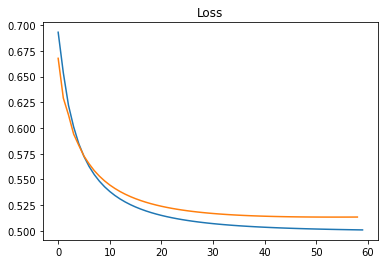

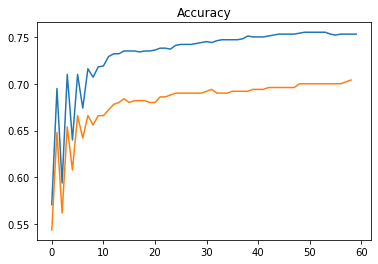

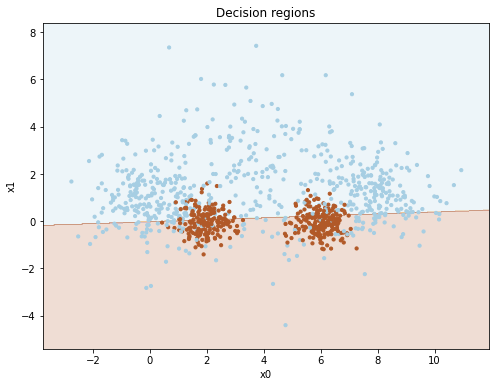

In [164]:
cl = NumpyLogRegClass()
tol, epo = 10**-4, 185
print("I found that this is the optimal value for tol ", tol)

best_eta = optimalHyperParam(X_train, tol, 0.05, epo, x=X_val, t=t2_val)
best_eta = round(best_eta, 2)
#cl.fit(X_train, t2_train, tol, eta=best_eta, epochs=epo, x_val=X_val, t_val=t2_val)
print("\nI found best eta possible should be ", best_eta)
print("But the best output of loss came with eta= 0.3, so I stuck to that")
cl.fit(X_train, t2_train, tol, eta=0.3, epochs=epo, x_val=X_val, t_val=t2_val)

print("Both hyper-params I found in the same way as in the tuning task.")

print("Training the data took", cl.get_ran_epochs(), "epochs.")
print("With the final hyper-meter settings, we have an accuracy on: ", accuracy(cl.predict(X_val), t2_val))
cl.plot_data()
plot_decision_regions(X_train, t2_train, cl)

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [165]:

class NumpyMultiClass(NumpyClassifier):
    #ran_epochs = 0

    def __init__(self, bias=-1):
        self.bias=bias
        self.cl = NumpyLogRegClass()
    
    def fit(self, X, t_multi, tol, n_epochs_no_update = 5, eta = 0.1, epochs = 10, x_val=None, t_val=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""

        i = 0
        self.classes = {}
        # making a target array for this particular class
        target_vals = (t_multi == i).astype('int')

        # runs until no more classes -> target-vals are only zeros
        while np.any(target_vals):
            cl = NumpyLogRegClass()
            cl.fit(X, target_vals, tol, n_epochs_no_update, eta, epochs, x_val, t_val)
            self.classes[i] = cl
            i += 1
            target_vals = (t_multi == i).astype('int')
        
    def predict(self, x):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""

        # extracting probabilites for every class according to val set
        scores = {}
        for key in self.classes.keys():
            clas = self.classes.get(key)
            score = clas.predict_probability(x)
            scores[key] = score

        # merging them into 1 array
        scores = [list(elem) for elem in zip(*scores.values())]

        # find the index of the highest class
        highest_scores = [np.argmax(class_scores) for class_scores in scores] 
        return np.array(highest_scores)
     

Accuracy:  0.79


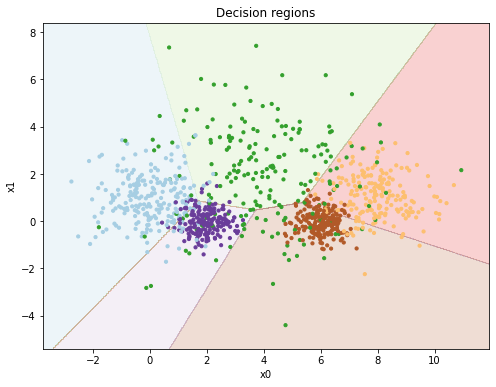

In [166]:
multi_cl = NumpyMultiClass()
# these are the best parameters i found
tol, epo, eta = 1*10**-4, 500, 0.34
multi_cl.fit(X_train, t_multi_train, tol, eta=eta, epochs=epo, x_val=X_val, t_val=t2_val)
print("Accuracy: ", accuracy(multi_cl.predict(X_val), t_multi_val))
p = multi_cl.predict(X_val)
plot_decision_regions(X_train, t_multi_train, multi_cl)



# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [167]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    ran_epochs = 0
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, tol, n_epochs_no_update = 5, eta=0.001, epochs = 100, x_val=None, t_val=None):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        self.losses, self.accuracies, self.losses_val, self.accuracies_val = [], [], [], []
        prevLoss, no_update, self.ran_epochs = float("inf"), 0, 0
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights

            loss = self.mse(t_train, self.predict(X_train))
            self.losses.append(loss)
            self.accuracies.append(accuracy(self.predict(X_train), t_train))    
            # Calc loss and accuracy

            if x_val is not None and t_val is not None :
                hidden_outs, outputs = self.forward(X_train_bias)
                self.losses_val.append(self.mse(t_val, self.predict(X_val)))
                self.accuracies_val.append(accuracy(self.predict(x_val), t_val))
            
            # Task d) messed up the plots, so I commented this
            if (prevLoss - loss) < tol:       #not improved more than tol
                no_update += 1
                if no_update == n_epochs_no_update:                    
                    break
            else:
                no_update = 0
                
            prevLoss = loss
            self.ran_epochs += 1
          
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
    
    def predict_probability(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return score

    def mse(self, y, y_pred):
        return np.mean((y - y_pred)**2)

    def CE_loss(self, t, y):    
        """ Compute binary cross entropy loss given predicted and true labels."""  
        loss = np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))
        return -loss
    
    def get_ran_epochs(self):
        return self.ran_epochs

    # function for plotting data
    def plot_data(self):
        plt.plot(self.losses)
        plt.plot(self.losses_val)
        plt.title("Loss")
        plt.show()
        plt.plot(self.accuracies)
        plt.plot(self.accuracies_val)
        plt.title("Accuracy")
        plt.show()
        

In [187]:
# helping method to find the best hyper-params to get the best accuracy
def tune(trainingdata, tol, epo, e, x=None, t=None):
    print("Starting tuning from dim_hidden = 6, tol = ", tol, "and eta = ", e)
    accuracies = {}
    eta = e
    cl.dim_hidden = 15
    #best_acc = float("-inf") #acc
    for j in range(8):
        e = eta
        for k in range(10):
            cl.fit(trainingdata, t2_train, tol, eta=e, epochs=epo, x_val=x, t_val=t)
            acc = accuracy(cl.predict(X_val), t2_val)
            accuracies[acc] = (e, tol, cl.dim_hidden)

            # if acc > best_acc:
            #     print(acc, "ble bedre enn ", best_acc)
            #     best_acc = acc
            #     best_cl = cl
            #     bests = (e, tol, cl.dim_hidden)
                
            e += -0.0002
        tol *= 10**-1
     
    return max(accuracies.items(), key=lambda x : x[0])



Starting tuning from dim_hidden = 6, tol =  1e-07 and eta =  0.0008


C:\Users\annic\AppData\Local\Temp\ipykernel_12304\4279889997.py:11: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


My tuning algorithm gave me an accuracy on  0.824 for these parameters: eta = 0.0004 , tol =  1.0000000000000005e-14 and dim_hidden =  15

Running 10 times of this classifier with the optimal hyper-params: 
Mean of the accuracies : 0.802
Standard deviation of the accuracies : 0.0
Best ran epochs:  1657


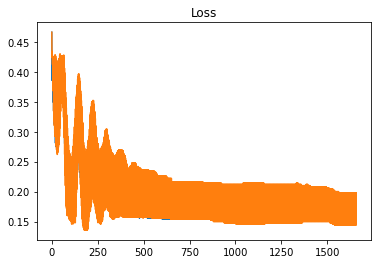

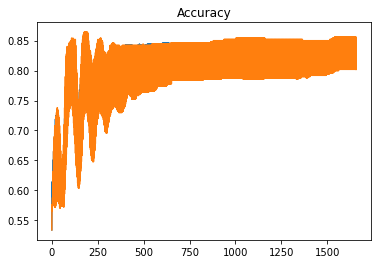

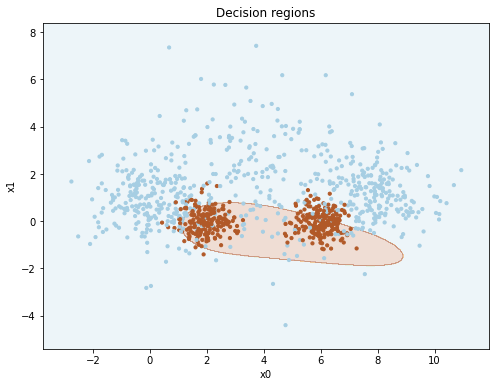

In [193]:
cl = MLPBinaryLinRegClass()
tol, epo, eta = 10**-7, 15000, 0.0008

# Task e) recommend running several times
acc, best = tune(X_train, tol, e = eta, epo = epo, x=X_val, t=t2_val)
eta, tol, dim = best[0], best[1], best[2]
print("My tuning algorithm gave me an accuracy on ", acc, "for these parameters: eta =", round(eta, 4), ", tol = ", tol, "and dim_hidden = ", dim)

accurs = []
print("\nRunning 10 times of this classifier with the optimal hyper-params: ")
for i in range(1):
    cl.fit(X_train, t2_train, tol , eta = eta, epochs=epo, x_val=X_val, t_val=t2_val)
    cl.dim_hidden = 15
    accurs.append(accuracy(cl.predict(X_val), t2_val))
print("Mean of the accuracies :", np.mean(accurs))
print("Standard deviation of the accuracies :", np.std(accurs))
print("Best ran epochs: ", cl.get_ran_epochs())

cl.plot_data()
plot_decision_regions(X_train, t2_train, cl)


## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.


In [170]:
def precision(predicted, gold):
    tp = 0
    fp = 0

    for i in range(len(predicted)):
        if predicted[i] == gold[i]:
            tp += 1
        elif predicted[i] and not gold[i]:
            fp += 1

    precision = tp / (tp + fp)

    return precision


def recall(predicted, gold):
    tp = 0
    fn = 0

    for i in range(len(predicted)):
        if predicted[i] == gold[i]:
            tp += 1
        elif not predicted[i] and gold[i]:
            fn += 1

    recall = tp / (tp + fn)
    
    return recall

In [171]:
import pandas as pd
cl = NumpyLinRegClass()
best_eta, epo = 0.075, 185
cl.fit(X_train, t2_train, eta = best_eta, epochs=epo)
a = accuracy(cl.predict(X_train), t2_train)
a2 = accuracy(cl.predict(X_val), t2_val)

precision = precision(cl.predict(X_train), t2_train)
recall = recall(cl.predict(X_train), t2_train)

cl = NumpyLogRegClass()
best_eta, best_tol = 0.3, 0.0001
cl.fit(X_train, t2_train, tol = best_tol , eta = best_eta, epochs=epo, x_val=X_val, t_val=t2_val)
b = accuracy(cl.predict(X_train), t2_train)
b2 = accuracy(cl.predict(X_val), t2_val)

cl = MLPBinaryLinRegClass()
best_eta, best_tol = 0.0001, 10**-9
cl.fit(X_train, t2_train, tol , eta = eta, epochs=epo, x_val=X_val, t_val=t2_val)
c = accuracy(cl.predict(X_train), t2_train)
c2 = accuracy(cl.predict(X_val), t2_val)

data = {
  "LinReg": [a, a2],
  "LogReg": [b, b2], 
  "MLNLinReg": [c, c2]
}
df = pd.DataFrame(data, index = ["Train set", "Val set"])
print(df)

print("Precision", precision)
print("Recall: ", recall)


           LinReg  LogReg  MLNLinReg
Train set   0.751   0.753      0.614
Val set     0.704   0.704      0.576
Precision 0.8702201622247973
Recall:  0.8457207207207207
